In [1]:
import os
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.transforms as transforms
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root_path = r"D:\dataset\eye\Train"

In [3]:
csv_path = root_path + "/Train.csv"

In [4]:
data_source = pd.read_csv(csv_path)

In [5]:
data_key = [ "Impression", "HyperF_Type", "HyperF_Area(DA)", "HyperF_Fovea", "HyperF_ExtraFovea", "HyperF_Y", 
      "HypoF_Type" ,"HypoF_Area(DA)","HypoF_Fovea", "HypoF_ExtraFovea"
    ,"HypoF_Y","CNV","Vascular abnormality (DR)","Pattern"]

In [6]:
class CONDITION:
    def __init__(self, name, idx, belong_name, belong_idx):
        self.name = name
        self.idx = idx
        self.belong_name = belong_name
        self.belong_idx = belong_idx

In [7]:
def anylaized(data_source):
    data_key = [ "Impression", "HyperF_Type", "HyperF_Area(DA)", "HyperF_Fovea", "HyperF_ExtraFovea", "HyperF_Y", 
      "HypoF_Type" ,"HypoF_Area(DA)","HypoF_Fovea", "HypoF_ExtraFovea"
    ,"HypoF_Y","CNV","Vascular abnormality (DR)","Pattern"]
    discribe_word = {}
    discribe_key_word = {}
    discribe_key_index = {}
    index = 0
    
    for keyword in data_key:
        discribe_key_index[keyword] = index
        index += 1
        impress_type = {}
        for i in data_source[keyword]:
            #if i is None:
            if i is np.nan:
                i = 'nan'
            word_list = i.split(',')
            for word in word_list:
                if word == '':
                    continue
                if word not in impress_type:
                    impress_type[word] = 1
                else:
                    impress_type[word] += 1
        discribe_key_word[keyword] = impress_type
        for key, value in impress_type.items():
            if key not in discribe_word:
                discribe_word[key] = 1
            else:
                discribe_word[key] += 1
    return discribe_word, discribe_key_word, discribe_key_index

In [8]:
def encode_row(discribe_key_word, discribe_key_index, discribe_word, data_key):
    index = 0
    gt_row_name2index_dict = {}
    for i in data_key:
        gt_row_name2index_dict[i] = index
        index += 1
    gt_dict = {}
    gt_index2name_dict = {}
    key_index = 0
    for key, value in discribe_key_word.items(): 
        gt_dict[key] = {}
        gt_index2name_dict[gt_row_name2index_dict[key]] = {}
        index = 0
        for gt_key_name in value.keys():
            gt_dict[key][gt_key_name] = index
            gt_index2name_dict[gt_row_name2index_dict[key]][index]=gt_key_name 
            discribe_word[gt_key_name] = CONDITION( gt_key_name, index, key, discribe_key_index[key] )
            # print(gt_key_name)
            index += 1
    return gt_dict, gt_index2name_dict, discribe_word

In [76]:
len(gt_index2name_dict[0])

23

In [64]:
discribe_word, discribe_key_word, discribe_key_index = anylaized(data_source)

In [66]:
gt_dict, gt_index2name_dict, discribe_word = encode_row(discribe_key_word, discribe_key_index, discribe_word, data_key)

In [9]:
from torch.utils.data import Dataset
import traceback
class DataLoad(Dataset):
    def __init__(self, root_path = r"D:\dataset\eye\Train" , image_shape = (384,384) ) -> None:
        self.root_path = root_path
        csv_path = root_path + "/Train.csv"
        self.image_shape = image_shape
        self.data_source = pd.read_csv(csv_path)
        data_key = [ "Impression", "HyperF_Type", "HyperF_Area(DA)", "HyperF_Fovea", "HyperF_ExtraFovea", "HyperF_Y", 
          "HypoF_Type" ,"HypoF_Area(DA)","HypoF_Fovea", "HypoF_ExtraFovea"
        ,"HypoF_Y","CNV","Vascular abnormality (DR)","Pattern"]
        
        discribe_word, discribe_key_word, discribe_key_index = anylaized(self.data_source)
        gt_dict, gt_index2name_dict, discribe_word = encode_row(discribe_key_word, discribe_key_index, discribe_word, data_key)
        self.gt_dict = gt_dict
        self.gt_index2name_dict = gt_index2name_dict
        self.discribe_word = discribe_word
        self.data_key = data_key
        
        index = 0
        self.data_key2index = {}
        self.data_key_len = {}
        
        for i in data_key:
            self.data_key2index[i] = index
            self.data_key_len[index] = len(self.gt_dict[i])
            index+=1
        
        self.load_data(self.data_source)
        self.one_hot_label_set()
        self.set_gan()
        
    def check_word(self, discribe):
        if discribe is np.nan:
            discribe = 'nan'
        word_list = discribe.split(',')
        ans = []
        for word in word_list:
            if word == '':
                continue
            ans.append(word)
        return ans
    
    def one_hot_label_set(self):
        self.photo_set_one_hot = []
        for obj in self.photo_set:
            data_key_idx = 0
            # [[1,3], [1], [2], [0], [0], [0], [0], [2], [0], [0], [0], [0], [0], [0]]
            gt_data_key = []
            for data_key_item_gt in obj['gt']:
                total = self.data_key_len[data_key_idx]
                label_one_hot = np.zeros(total)
                
                for msg in data_key_item_gt:
                    label_one_hot[msg] = 1
                gt_data_key.append( label_one_hot )
                data_key_idx += 1 
            
            # 左右两张图
            self.photo_set_one_hot.append({
                'image':obj['image'],
                'gt':obj['gt'],
                'gt_oh':gt_data_key,
                'direct':1,
            })
            self.photo_set_one_hot.append({
                'image':obj['image'],
                'gt':obj['gt'],
                'gt_oh':gt_data_key,
                'direct':0,
            })
            
    def load_data(self, data_source):
        photo_set = []
        img_root_path = self.root_path + "/Train/"
        for index, row in data_source.iterrows():
            gt_index = []
            for discribe_list in row[:-2]:
                discribe_list = self.check_word(discribe_list)
                for discribe in discribe_list:
                    temp_gt_idx = []
                    code = self.discribe_word[discribe].idx
                    temp_gt_idx.append( code )
                gt_index.append(temp_gt_idx)
            file_folder = row[-1]
            file_path = img_root_path + file_folder + "/"
            if os.path.exists(file_path):
                file_name_list = os.listdir(file_path)
                for file_name in file_name_list:
                    img_obj = {
                        "image" : file_path  + file_name,
                        "gt" : gt_index,
                    }
                    photo_set.append(img_obj)
            else:
                print(file_path, "not exists!"  )
                
        self.photo_set = photo_set
        self.total_number = len(self.photo_set)
        print("total load data:", self.total_number)
    
    def read_image(self, path, mode = 1): # 默认为彩色图
        return cv2.imread(path, mode)
    
    def set_gan(self, method_list = None):
        
        self.datagan = None
        self.datagan_gt = None
       
        if method_list is None:
            self.datagan = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(self.image_shape),
                transforms.RandomCrop(size = self.image_shape, padding=(10, 20)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(10),
                transforms.ToTensor(),      
                transforms.Normalize(0,1),
            ])
        else:
            self.datagan = transforms.Compose(method_list)
       
        method_list = [
            transforms.ToPILImage(),
            transforms.Resize(self.image_shape),
            transforms.ToTensor(),      
            transforms.Normalize(0,1),     
        ]
        self.datagan_val = transforms.Compose(method_list)
    
    def __len__(self):
        return len(self.photo_set)

    def __getitem__(self, index):
        """
        获取对应index的图像,并视情况进行数据增强
        """
        if index >= self.total_number:
            raise StopIteration
        try:
            re_index = index
            direct = 0
            image_src_path, image_gt = self.photo_set_one_hot[re_index]['image'], self.photo_set_one_hot[re_index]['gt_oh']
            if "direct" in self.photo_set_one_hot[re_index]:
                direct = self.photo_set_one_hot[re_index]['direct']
            img = self.read_image(image_src_path)
            
            if direct:
                img = img[:384,384:]
            else:
                img = img[:384,:384]
            
            img = self.datagan(img)
            image_gt = [ torch.from_numpy(gt) for gt in image_gt ]
            # image_gt = self.datagan_gt(image_gt)

            return img, image_gt
        except Exception as e:
            print("发现异常")
            print(e.__class__.__name__)
            print(e)
            print(index)
            print(traceback.print_exc())


In [35]:
for key, value in a.gt_index2name_dict.items():
    print(a.data_key[key], ":", len(value))

Impression : 23
HyperF_Type : 5
HyperF_Area(DA) : 3
HyperF_Fovea : 2
HyperF_ExtraFovea : 18
HyperF_Y : 4
HypoF_Type : 3
HypoF_Area(DA) : 3
HypoF_Fovea : 2
HypoF_ExtraFovea : 17
HypoF_Y : 5
CNV : 2
Vascular abnormality (DR) : 15
Pattern : 14


In [32]:
a.gt_index2name_dict

{0: {0: 'macular neovascularization',
  1: 'dry age-related macular degeneration',
  2: 'cystoid macular edema',
  3: 'unremarkable changes',
  4: 'central serous chorioretinopathy',
  5: 'pachychoroid pigment epitheliopathy',
  6: 'other',
  7: 'retinal pigment epithelial detachment',
  8: 'uveitis',
  9: 'chorioretinal scar',
  10: 'choroidal mass',
  11: 'diabetic retinopathy',
  12: 'myopia',
  13: 'chorioretinal atrophy',
  14: 'branch retinal vein occlusion',
  15: 'retinal vein occlusion',
  16: 'epiretinal membrane',
  17: 'proliferative diabetic retinopathy',
  18: 'central retinal vein occlusion',
  19: 'central retinal artery occlusion',
  20: 'polypoidal choroidal vasculopathy',
  21: 'retinal arterial macroaneurysm',
  22: 'retinal dystrophy'},
 1: {0: 'leakage', 1: 'staining', 2: 'no', 3: 'pooling', 4: 'window defect'},
 2: {0: '4', 1: '5', 2: 'no'},
 3: {0: 'yes', 1: 'no'},
 4: {0: 'no',
  1: 'nasal',
  2: 'superior',
  3: 'superior nasal',
  4: 'temporal',
  5: 'inferio

In [10]:
a = DataLoad()
a.set_gan()

C:\Users\DentaLink\AppData\Local\Temp\ipykernel_2980\1220350771.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file_folder = row[-1]


D:\dataset\eye\Train/Train/454_L/ not exists!
D:\dataset\eye\Train/Train/454_R/ not exists!
D:\dataset\eye\Train/Train/611_L/ not exists!
D:\dataset\eye\Train/Train/611_R/ not exists!
D:\dataset\eye\Train/Train/729_L/ not exists!
D:\dataset\eye\Train/Train/1412_L/ not exists!
D:\dataset\eye\Train/Train/1412_R/ not exists!
D:\dataset\eye\Train/Train/1417_L/ not exists!
D:\dataset\eye\Train/Train/1417_R/ not exists!
D:\dataset\eye\Train/Train/1425_L/ not exists!
D:\dataset\eye\Train/Train/1425_R/ not exists!
D:\dataset\eye\Train/Train/1426_L/ not exists!
D:\dataset\eye\Train/Train/1426_R/ not exists!
D:\dataset\eye\Train/Train/1427_L/ not exists!
D:\dataset\eye\Train/Train/1427_R/ not exists!
D:\dataset\eye\Train/Train/1429_L/ not exists!
D:\dataset\eye\Train/Train/1429_R/ not exists!
D:\dataset\eye\Train/Train/1430_L/ not exists!
D:\dataset\eye\Train/Train/1430_R/ not exists!
D:\dataset\eye\Train/Train/1431_L/ not exists!
D:\dataset\eye\Train/Train/1431_R/ not exists!
D:\dataset\eye\Tra

In [17]:
c = [ a.photo_set_one_hot for i in range(2)  ]

In [23]:
d = np.array(c).flatten()

In [24]:
len(d)

134236

In [14]:
len(c)

134236

In [78]:
for i in a:
    img, gt = i
    break

D:\dataset\eye\Train/Train/0_L/0.jpg [array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0.]), array([1., 0., 0.]), array([1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([1., 0., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0.]), array([1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
(384, 384, 3)


In [88]:
a.data_key2index, a.gt_index2name_dict

({'Impression': 0,
  'HyperF_Type': 1,
  'HyperF_Area(DA)': 2,
  'HyperF_Fovea': 3,
  'HyperF_ExtraFovea': 4,
  'HyperF_Y': 5,
  'HypoF_Type': 6,
  'HypoF_Area(DA)': 7,
  'HypoF_Fovea': 8,
  'HypoF_ExtraFovea': 9,
  'HypoF_Y': 10,
  'CNV': 11,
  'Vascular abnormality (DR)': 12,
  'Pattern': 13},
 {0: {0: 'macular neovascularization',
   1: 'dry age-related macular degeneration',
   2: 'cystoid macular edema',
   3: 'unremarkable changes',
   4: 'central serous chorioretinopathy',
   5: 'pachychoroid pigment epitheliopathy',
   6: 'other',
   7: 'retinal pigment epithelial detachment',
   8: 'uveitis',
   9: 'chorioretinal scar',
   10: 'choroidal mass',
   11: 'diabetic retinopathy',
   12: 'myopia',
   13: 'chorioretinal atrophy',
   14: 'branch retinal vein occlusion',
   15: 'retinal vein occlusion',
   16: 'epiretinal membrane',
   17: 'proliferative diabetic retinopathy',
   18: 'central retinal vein occlusion',
   19: 'central retinal artery occlusion',
   20: 'polypoidal choroid

In [85]:
gt[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], dtype=torch.float64)

In [92]:
np.argmax(gt[0])

tensor(0)

In [95]:
row_id = 0
"name", a.gt_index2name_dict[row_id][np.argmax(gt[row_id]).item()]

('name', 'macular neovascularization')

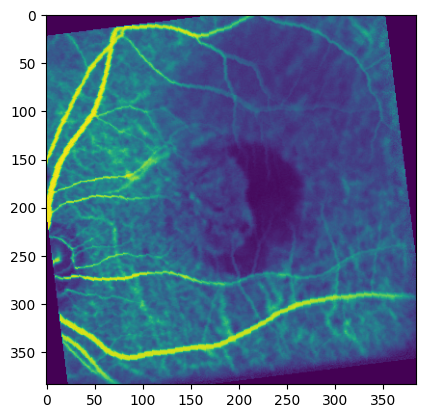

In [81]:
plt.imshow(img[0])
plt.show()

In [14]:
a.photo_set_one_hot[1078]

{'image': 'D:\\dataset\\eye\\Train/Train/76_R/14.jpg',
 'gt': [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [2]],
 'gt_oh': [array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0.]),
  array([1., 0., 0.]),
  array([1., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]),
  array([1., 0., 0., 0.]),
  array([1., 0., 0.]),
  array([1., 0., 0.]),
  array([1., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0.]),
  array([1., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]}

In [113]:
len(a.gt_dict['Impression'])

23

In [109]:
a.gt_dict

{'Impression': {'macular neovascularization': 0,
  'dry age-related macular degeneration': 1,
  'cystoid macular edema': 2,
  'unremarkable changes': 3,
  'central serous chorioretinopathy': 4,
  'pachychoroid pigment epitheliopathy': 5,
  'other': 6,
  'retinal pigment epithelial detachment': 7,
  'uveitis': 8,
  'chorioretinal scar': 9,
  'choroidal mass': 10,
  'diabetic retinopathy': 11,
  'myopia': 12,
  'chorioretinal atrophy': 13,
  'branch retinal vein occlusion': 14,
  'retinal vein occlusion': 15,
  'epiretinal membrane': 16,
  'proliferative diabetic retinopathy': 17,
  'central retinal vein occlusion': 18,
  'central retinal artery occlusion': 19,
  'polypoidal choroidal vasculopathy': 20,
  'retinal arterial macroaneurysm': 21,
  'retinal dystrophy': 22},
 'HyperF_Type': {'leakage': 0,
  'staining': 1,
  'no': 2,
  'pooling': 3,
  'window defect': 4},
 'HyperF_Area(DA)': {'4': 0, '5': 1, 'no': 2},
 'HyperF_Fovea': {'yes': 0, 'no': 1},
 'HyperF_ExtraFovea': {'no': 0,
  'nas

In [103]:
index = 0
for i in data_key:
    a.gt_dict[i] = index
    index+=1

In [99]:
a.gt_index2name_dict[0][1], a.gt_index2name_dict[1][1], a.gt_index2name_dict[2][2]

('dry age-related macular degeneration', 'staining', 'no')

In [8]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None,max_images =10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.max_images = max_images

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        folder_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, -1])
        image_count = len(os.listdir(folder_name))
        print("folder {}".format(folder_name))
        
        images = [Image.open(os.path.join(folder_name, f"{i}.jpg")) for i in range(image_count)]
        print("images {}".format(len(images)))
        
        # Normalize and convert images to tensor
        if self.transform:
            images = [self.transform(image) for image in images]
        
        while len(images) < self.max_images:
            zero_tensor = torch.zeros([3, 224, 224])  # Assuming the images are 224x224 and 3-channel after transformation
            images.append(zero_tensor)
        images = torch.stack(images)  # Assuming all images in folder are related and stacking them into a single tensor
        
        labels = self.data_frame.iloc[idx, :-2]  # Excluding ID and Folder columns
        labels = torch.tensor(labels.values.astype('float32'))
        
        return images, labels

In [9]:

# Transformation (Normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224 for example
    transforms.ToTensor(),  # Transform it to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing
])


In [13]:

dataset = CustomDataset(csv_file=csv_path, root_dir=root_path, transform=transform)

def collate_fn(batch):
    images, labels = zip(*batch)
    
    # Pad images
    images = pad_sequence(images, batch_first=True, padding_value=0)
    
    # Stack labels
    labels = torch.stack(labels)
    
    return images, labels

# DataLoader with custom collate_fn
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Display a sample batch
for i_batch, (images, labels) in enumerate(dataloader):
    print(f"Batch {i_batch + 1}")
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break  # Display only one batch


folder F:\Train\Train\1578_L
images 9
folder F:\Train\Train\745_L
images 23
folder F:\Train\Train\512_R
images 3
folder F:\Train\Train\187_L
images 14
Batch 1
Images shape: torch.Size([4, 23, 3, 224, 224]), Labels shape: torch.Size([4, 14])


##  处理csv文件

In [11]:


from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 读取CSV文件
data_frame = pd.read_csv('F:/Train/Train/Train.csv')

# 初始化LabelEncoder
label_encoder = LabelEncoder()

# 创建一个新的DataFrame用于存储转换后的数据
transformed_data_frame = data_frame.copy()

# 对每一个标签列应用LabelEncoder
for column in data_frame.columns[:-2]:  # 排除 ID 和 Folder 列
    transformed_data_frame[column] = label_encoder.fit_transform(data_frame[column])

# 保存转换后的DataFrame
transformed_data_frame.to_csv('F:/Train/Transformed_Train.csv', index=False)
